# 4. Stitch outputs together
- Once you have fitted the weak, medium and dense diads, stitch them all together, and apply the Ne correction model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import DiadFit as pf
pf.__version__

'0.0.78'

In [2]:
# Load in settings, paths, file extensions etc. that you saved in step 1
meta_path, spectra_path, filetype, prefix, prefix_str, file_ext, TruPower=pf.get_settings()

## Load in specra, and combine

In [3]:
import os
df2=pf.merge_fit_files(path=os.getcwd())

## First, get the metadata for this day

In [4]:
# Put the common string you can in all your Ne lines here
diad_meta=pf.get_files(path=meta_path,
file_ext=file_ext, exclude_str=['Ne', 'FG', 'Cap','window'],
 sort=True)
diad_meta[0]

'NE22.txt'

## Now get all the important information out of the metadata files

In [5]:
# This will only work for WITEC - for other vendors, you might have to use the file datastamp. See the HORIBA example
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=diad_meta, prefix=prefix, str_prefix=prefix_str,
trupower=TruPower)
meta.head()

  0%|          | 0/114 [00:00<?, ?it/s]

100%|██████████| 114/114 [01:36<00:00,  1.18it/s]

Done
Oof, try not to work after midnight!


,filename,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
99,POC49.txt,"November 29, 2020\n",November,29.0,NaN,45.0,5.0,5.0,"['0h', '3m', '46s']",12:02:59 AM\n,86579.0,1341.0
46,NE68.txt,"November 29, 2020\n",November,29.0,NaN,45.0,3.0,5.0,"['0h', '2m', '16s']",12:07:01 AM\n,86821.0,1341.0
101,POC50.txt,"November 29, 2020\n",November,29.0,NaN,45.0,5.0,5.0,"['0h', '3m', '46s']",12:09:42 AM\n,86982.0,1341.0
47,NE69.txt,"November 29, 2020\n",November,29.0,NaN,45.0,3.0,5.0,"['0h', '2m', '16s']",12:14:20 AM\n,87260.0,1341.0
102,POC51.txt,"November 29, 2020\n",November,29.0,NaN,60.0,3.0,5.0,"['0h', '3m', '2s']",12:17:28 AM\n,87448.0,1341.0


## Then get a simple file name you can stitch with the spectra

In [6]:
file_m=pf.extracting_filenames_generic(names=meta['filename'],
   file_ext=file_ext)
# Checks they are all unique
file_m[0]

good job, no duplicate file names


'POC49'

## Now get filename from spectra into same form as metadata

In [7]:
# Remove these to get the pure file name
file_s=pf.extracting_filenames_generic(
    names=df2['filename'].reset_index(drop=True),
   file_ext=file_ext)

# Remove the cosmic rays, as doesnt have it in the metatdata
file_s = np.char.replace(file_s.astype(str), "_CRR_DiadFit", "")
print(file_s[0])

good job, no duplicate file names
Cap19-05X2


In [8]:
# Combining them together, if the form above matches, e.g. checking one doesnt have a suffix and the other one does

meta['filename']=file_m
df2['filename']=file_s
df_combo=pd.merge(df2, meta, on='filename').reset_index(drop=True)
df_combo.head()

,filename,Splitting,Split_σ,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,...,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
0,POC51,102.740087,0.010524,1286.697192,0.009198,180.748510,1286.697192,239.567053,0.614586,2.696706,...,November,29.0,NaN,60.0,3.0,5.0,"['0h', '3m', '2s']",12:17:28 AM\n,87448.0,1341.0
1,POC52,102.734380,0.009421,1286.689692,0.008328,245.538346,1286.689692,313.494011,0.595481,3.724453,...,November,29.0,NaN,90.0,3.0,5.0,"['0h', '4m', '31s']",12:31:31 AM\n,88291.0,1341.0
2,POC53,102.760558,0.009698,1286.675397,0.008268,219.858570,1286.675397,284.179327,0.604810,2.925837,...,November,29.0,NaN,90.0,3.0,5.0,"['0h', '4m', '32s']",12:39:13 AM\n,88753.0,1341.0
3,POC54,102.759262,0.012019,1286.683864,0.010398,183.869660,1286.683914,241.653289,0.617334,2.796396,...,November,29.0,NaN,90.0,3.0,5.0,"['0h', '4m', '32s']",12:46:57 AM\n,89217.0,1341.0
4,POC55,102.727825,0.014096,1286.707696,0.012582,156.794386,1286.707696,208.195957,0.623706,2.929875,...,November,29.0,NaN,90.0,3.0,5.0,"['0h', '4m', '32s']",12:54:26 AM\n,89666.0,1341.0


## If you have secondary phases, now is the time to merge those in

In [9]:
df_combo_sec_phase=pf.merge_in_carb_SO2(
df_combo=df_combo, file1_name='Carb_Peak_fits.xlsx', file2_name='SO2_Peak_fits.xlsx', 
prefix=prefix, str_prefix=prefix_str, file_ext=file_ext)
#df_combo_sec_phase.to_excel('FI_fitting_w_sec_phases.xlsx', index=False)

## If you have SO2, now is the time to calculate the molar proportion of SO2

In [10]:
if 'Peak_Area_SO2' in df_combo_sec_phase:
    SO2_ratio=pf.calculate_CO2_SO2_ratio(peak_area_SO2=df_combo_sec_phase['Peak_Area_SO2'], 
    peak_area_diad1=df_combo_sec_phase['Diad1_Voigt_Area'], peak_area_diad2=df_combo_sec_phase['Diad2_Voigt_Area'],
    wavelength=532.067, T_K=37+273.15,efficiency_SO2=1, efficiency_CO2=0.5, 
    sigma_SO2=4.03, sigma_CO2_v1=0.8, sigma_CO2_v2=1.23)
    df_combo_sec_phase['SO2_mol_ratio']=SO2_ratio['SO2']

### This cell saves the merged together dataframe with the folder name and the date you fitted it

In [11]:

# df to save
df=df_combo_sec_phase
from datetime import date
today = date.today()
today_str = today.strftime("%Y-%m-%d")
sorted_df = df.sort_values('sec since midnight')
date=meta['date'].iloc[0].replace('\n', '')
name='Raman_session_'+date+'_fitted_'+today_str+'.xlsx'
print(name)
sorted_df.to_excel(name)

Raman_session_November 29, 2020_fitted_2023-11-09.xlsx


## Other things like HB ara ratios

(0.06, 0.13)

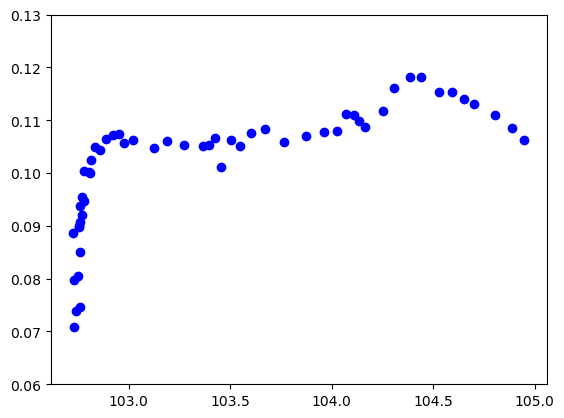

In [19]:
df_combo_sec_phase_c=pf.calculate_HB_Diad_area_ratio(df=df_combo_sec_phase)
plt.plot(df_combo_sec_phase['Splitting'], df_combo_sec_phase_c['HB_Diad_Ratio'], 'ob', label='LP sensor')
plt.ylim([0.06, 0.13])